## CMIP6 Interpolation Methods

## **Bilinear Interpolation**

Let $f(s,t)$ be a real-valued function with a two-dimensional input $(s,t)$. 

Assume we observe the function values $f(s_1,t_1)$, $f(s_1,t_2)$, $f(s_2,t_1)$, and $f(s_2,t_2)$. 

Now consider any $(s,t)$ within the rectangle defined by $(s_1,t_1)$, $(s_1,t_2)$, $(s_2,t_1)$, and $(s_2,t_2)$ where $s_1 < s < s_2$ and $t_1 < t < t_2$. 

Bilinear interpolation is conducted in two parts:

#### Part 1: Interpolate in s-direction

\begin{equation}
    f(s,t_1) = \frac{s_2 - s}{s_2 - s_1}\;f(s_1,t_1) + \frac{s - s_1}{s_2 - s_1}\;f(s_2,t_1)
\end{equation}


\begin{equation}
    f(s,t_2) = \frac{s_2 - s}{s_2 - s_1}\;f(s_1,t_2) + \frac{s - s_1}{s_2 - s_1}\;f(s_2,t_2)
\end{equation}

#### Part 2: Interpolate in t-direction

\begin{equation}
    f(s,t) = \frac{t_2 - t}{t_2 - t_1}\;f(s,t_1) + \frac{t - t_1}{t_2 - t_1}\;f(s,t_2)
\end{equation}



## **Nearest Neighbor**

This method chooses $f(\boldsymbol{x})$ using the nearest neighbor of $\boldsymbol{x}$ from the observed dataset.


## **Inverse Distance Weighting**

This method computes the distance between the target location $\boldsymbol{x}$ and the $n$ sample locations $\boldsymbol{x}_i,\ldots,\boldsymbol{x}_n$. 

Then, the prediction at $\boldsymbol{x}$ is computed by a weighted average 

\begin{equation}
    f(\boldsymbol{x}) = \frac{\sum_{i = 1}^n w_i(\boldsymbol{x}) f(\boldsymbol{x}_i)}{\sum_{i = 1}^n w_i(\boldsymbol{x})}
\end{equation}

where $w_i(\boldsymbol{x}) = 1/d(\boldsymbol{x},\boldsymbol{x}_i)$ for some distance metric $d()$.

The inverse weighting scheme can be improved by limiting the weighted average to a local neighborhood around $\boldsymbol{x}$ with radius $R$.

Lastly, if $\boldsymbol{x} = \boldsymbol{x}_i$ for some $i$, then $f(\boldsymbol{x}) = f(\boldsymbol{x}_i)$. 

In [26]:
import pandas as pd
import numpy as np
import os
import sys
import xarray as xr 
import netCDF4 as nc
import cftime
import matplotlib.pyplot as plt
from tqdm import tqdm

scidata_path = os.getcwd().split("SciData")[0] + "SciData"
sys.path.append(scidata_path)

from Climate.src.interpolators import bilinear, nearest_neighbor, invdw


In [10]:
#----------------------------------------------------------
# Functions
#----------------------------------------------------------
def get_timeperiod(f):
    rng = f.split('_')[-1][:-3]
    return [int(s[:-2]) for s in rng.split('-')]


In [14]:
#----------------------------------------------------------
# TAS from list
#----------------------------------------------------------
cmip6path = "/home/johnyannotty/NOAA_DATA/CMIP6/"
#filename = "tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc"
#filename =  "tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc"
#dset = xr.open_dataset(cmip6path+filename, decode_times=True, use_cftime=True)

file_list = sorted(os.listdir(cmip6path))
file_list = [f for f in file_list if "tas_" in f]
tas_data = []
lat_data = []
lon_data = []
fillval_data = []
i = 0
for f in file_list:
    ncdata = nc.Dataset(cmip6path + f, "r")
    print(i)

    # Get index and appropriate time period
    tp = get_timeperiod(f)
    n_begin = (1950 - tp[0]) * 12
    n_end = (2015 - tp[0]) * 12

    # Pull the temperature data using the indexes & convert to celsius 
    xi = ncdata.variables['tas'][n_begin:n_end]
    xi = np.array(xi)
    xi = np.array(xi) - 272.15
    
    # Rotate and flip to get the eastern and western hemisphere oriented correctly
    #xi = np.rot90(xi, k = 2, axes = (1, 2))
    #xi = np.flip(xi, axis = 2)

    # Get the fill values
    fv = ncdata.variables['tas']._FillValue

    # Get longitude and latitude
    lat = np.array(ncdata.variables["lat"])
    lon = np.array(ncdata.variables["lon"])

    # Append to lists
    tas_data.append(xi)
    lat_data.append(lat)
    lon_data.append(lon)
    fillval_data.append(fv)
    i+=1



0
1
2


/tmp/ipykernel_19941/826961768.py:26: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  xi = ncdata.variables['tas'][n_begin:n_end]


3
4
5
6
7
8


In [11]:
#----------------------------------------------------------
# ERA5 Pull
#----------------------------------------------------------
era5path = "/home/johnyannotty/NOAA_DATA/ERA5/"
ncdata = nc.Dataset(era5path + 'era5_avg_mon_tas/data_1990-2023.nc', "r")

y = ncdata.variables['t2m']
era5_lon = np.array(ncdata.variables['longitude'])
era5_lat = np.array(ncdata.variables['latitude'])

del ncdata

In [12]:
# Read in ERA5 in a different format
era5 = xr.open_dataset(era5path + 'era5_avg_mon_tas/data_1990-2023.nc', decode_times=True, use_cftime=True)

In [62]:
file_list[0:4]

['tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
 'tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 'tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc',
 'tas_Amon_CMCC-CM2-SR5_historical_r1i1p1f1_gn_185001-201412.nc']

In [79]:
#----------------------------------------------------------
# CMIP6 interpolations -- Access-CM2
#----------------------------------------------------------
cmip6intpath = '/home/johnyannotty/NOAA_DATA/CMIP6_Interpolations/'
cmpi6_interp_files = file_list[0:4]
for c,f in enumerate(cmpi6_interp_files):
    #f = file_list[0]
    #f = f.split("185")[0] + "2005-2015.nc"
    f = f.split("185")[0] + "2015.nc"
    ncfile = nc.Dataset(cmip6intpath + f,mode='w',format='NETCDF4_CLASSIC')

    lat_dim = ncfile.createDimension('lat', era5_lat.shape[0])     # latitude axis
    lon_dim = ncfile.createDimension('lon', era5_lon.shape[0])    # longitude axis
    time_dim = ncfile.createDimension('time', 12)#tas_data[0].shape[0]) # unlimited axis (can be appended to).

    ncfile.title=f
    ncfile.subtitle='TAS Interpolations'

    lat = ncfile.createVariable('lat', np.float32, ('lat',))
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.float32, ('lon',))
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'months since 1950-01-01'
    time.long_name = 'time'

    temp = ncfile.createVariable('tas',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
    temp.units = 'C'
    temp.standard_name = 't2m'


    # Batch Interpolations....(batch over time, long and lat)
    batch_sz = 100 # number of columns per batch with 1440 rows 
    ncol = era5_lon.shape[0]
    #num_tpds = tas_data[0].shape[0] # number of time periods
    num_tpds = 1 # last 10 years of data
    era5_lat_flip = np.flip(era5_lat)

    for i in tqdm(range(num_tpds),desc = "Time Period",leave=False):
        tm = tas_data[0].shape[0] - num_tpds + i
        for b in tqdm(range(int(np.ceil(era5_lat.shape[0]/batch_sz))),desc = "Batch",leave=False):
            nrow = min(batch_sz, era5_lat.shape[0]-b*batch_sz)
            temp0 = np.array(-999.0).repeat(nrow*ncol).reshape(nrow,ncol)
            for j in range(ncol):
                x0 = era5_lon[j]
                for k in range(nrow):
                    #y0 = era5_lat_flip[b*batch_sz+k]
                    y0 = era5_lat[b*batch_sz+k]            
                    temp0[k,j] = bilinear(x0, y0, np.array(lon_data[c]),np.array(lat_data[c]),tas_data[c][tm])
            temp[i,range(100*b,nrow+100*b),:] = temp0

    ncfile.close()

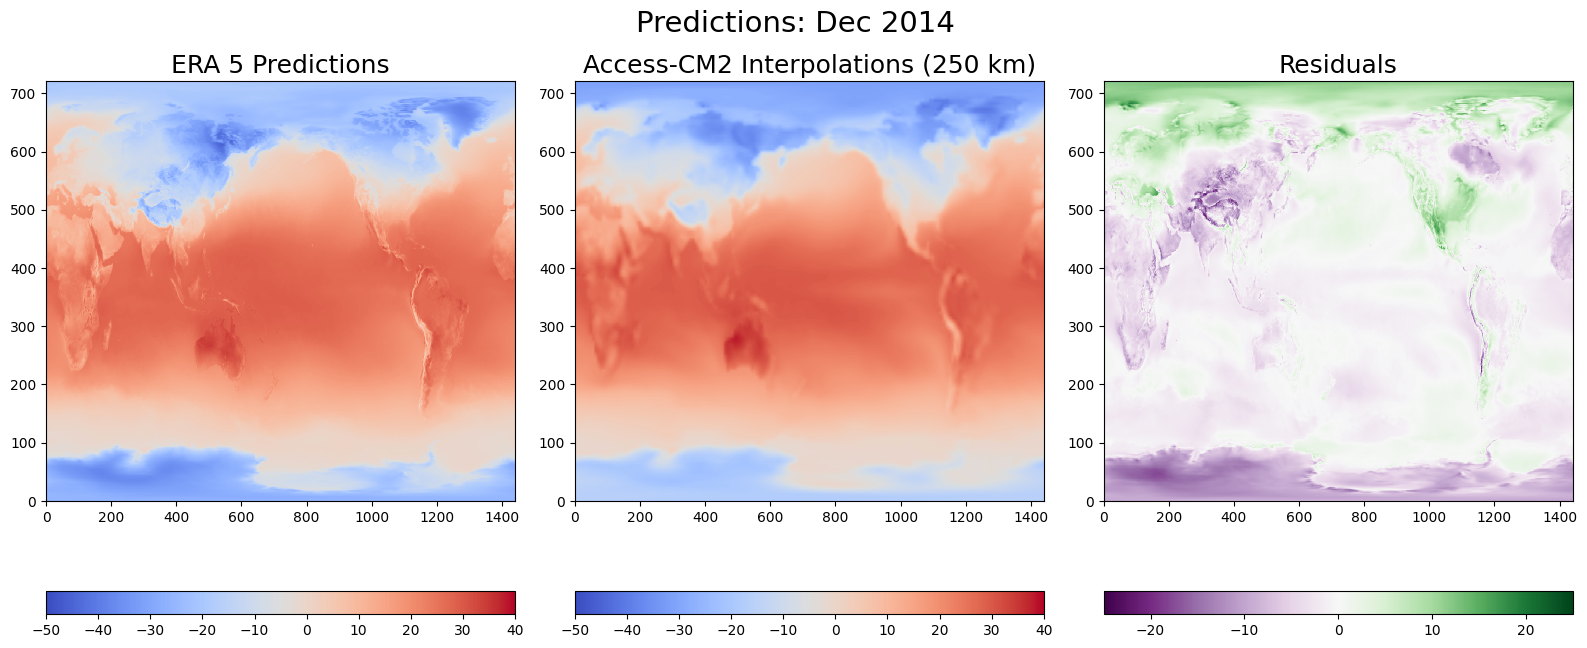

In [86]:
# Plot data
f = cmpi6_interp_files[0].split("185")[0] + "2015.nc"
ncdata1 = nc.Dataset(cmip6intpath + f, "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid1 = era5["t2m"][xx,0,:,:] - 272.15 - ncdata1["tas"][0]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(era5["t2m"][xx,0,:,:].transpose() - 272.15),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
#ax[0][1].pcolormesh(np.rot90(np.flip(ncdata2['tas'][0].transpose()),k=2))
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata1['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid1.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("ERA 5 Predictions", size = 18)
ax[1].set_title("Access-CM2 Interpolations (250 km)", size = 18)
ax[2].set_title("Residuals", size = 18)
fig.suptitle("Predictions: Dec 2014", size = 21)
fig.tight_layout()
plt.show()


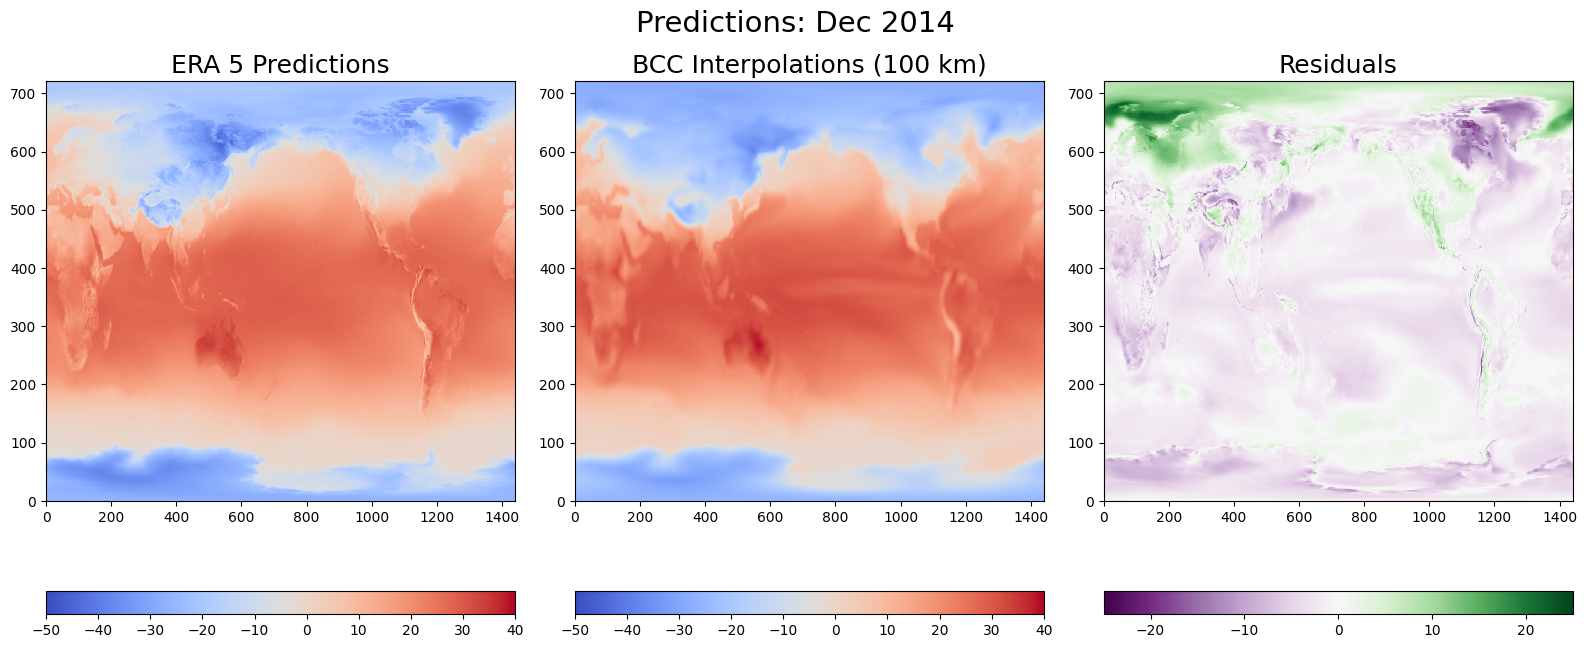

In [87]:
# Plot data
f = cmpi6_interp_files[1].split("185")[0] + "2015.nc"

ncdata2 = nc.Dataset(cmip6intpath + f, "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid2 = era5["t2m"][xx,0,:,:] - 272.15 - ncdata2["tas"][0]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(era5["t2m"][xx,0,:,:].transpose() - 272.15),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
#ax[0][1].pcolormesh(np.rot90(np.flip(ncdata2['tas'][0].transpose()),k=2))
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata2['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid2.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("ERA 5 Predictions", size = 18)
ax[1].set_title("BCC Interpolations (100 km)", size = 18)
ax[2].set_title("Residuals", size = 18)
fig.suptitle("Predictions: Dec 2014", size = 21)
fig.tight_layout()
plt.show()


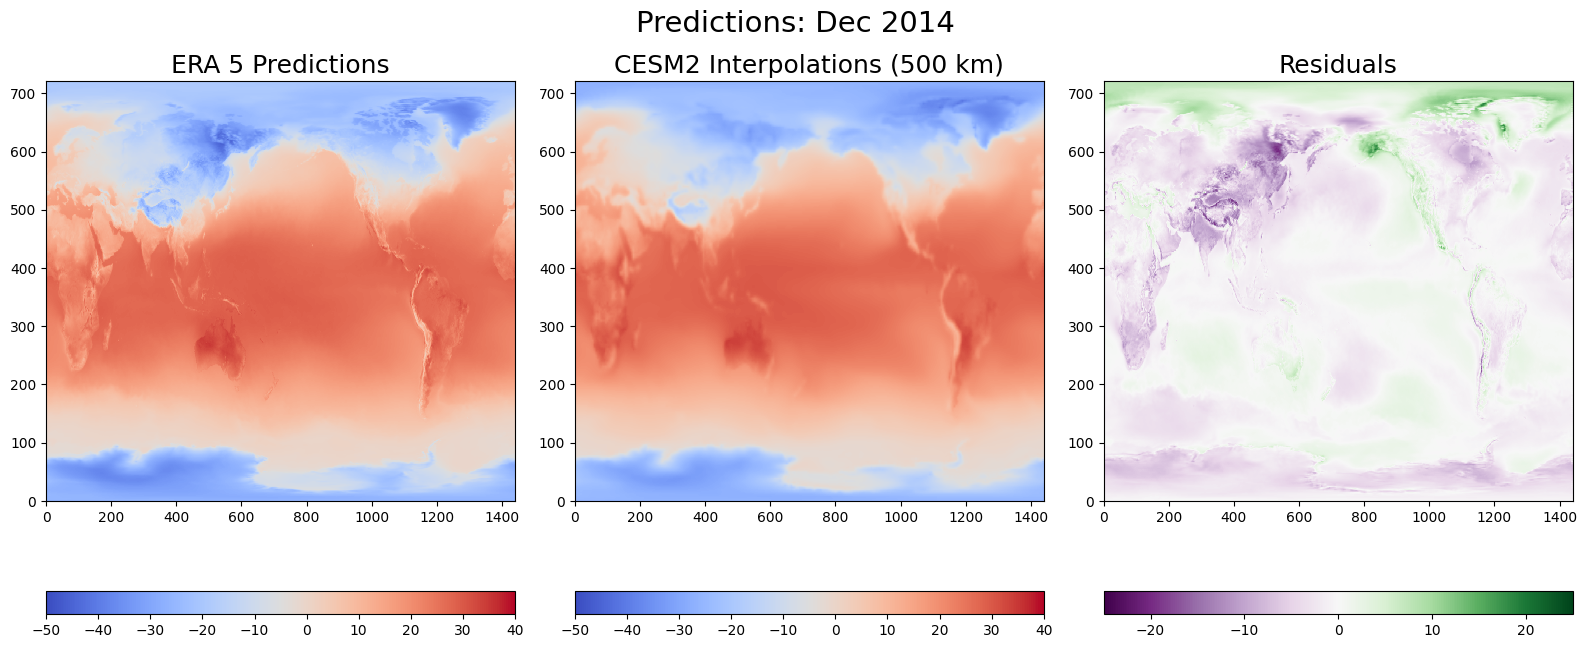

In [93]:
# Plot data
f = cmpi6_interp_files[2].split("185")[0] + "2015.nc"

ncdata3 = nc.Dataset(cmip6intpath + f, "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid3 = era5["t2m"][xx,0,:,:] - 272.15 - ncdata3["tas"][0]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(era5["t2m"][xx,0,:,:].transpose() - 272.15),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
#ax[0][1].pcolormesh(np.rot90(np.flip(ncdata2['tas'][0].transpose()),k=2))
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata3['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid3.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("ERA 5 Predictions", size = 18)
ax[1].set_title("CESM2 Interpolations (500 km)", size = 18)
ax[2].set_title("Residuals", size = 18)
fig.suptitle("Predictions: Dec 2014", size = 21)
fig.tight_layout()
plt.show()


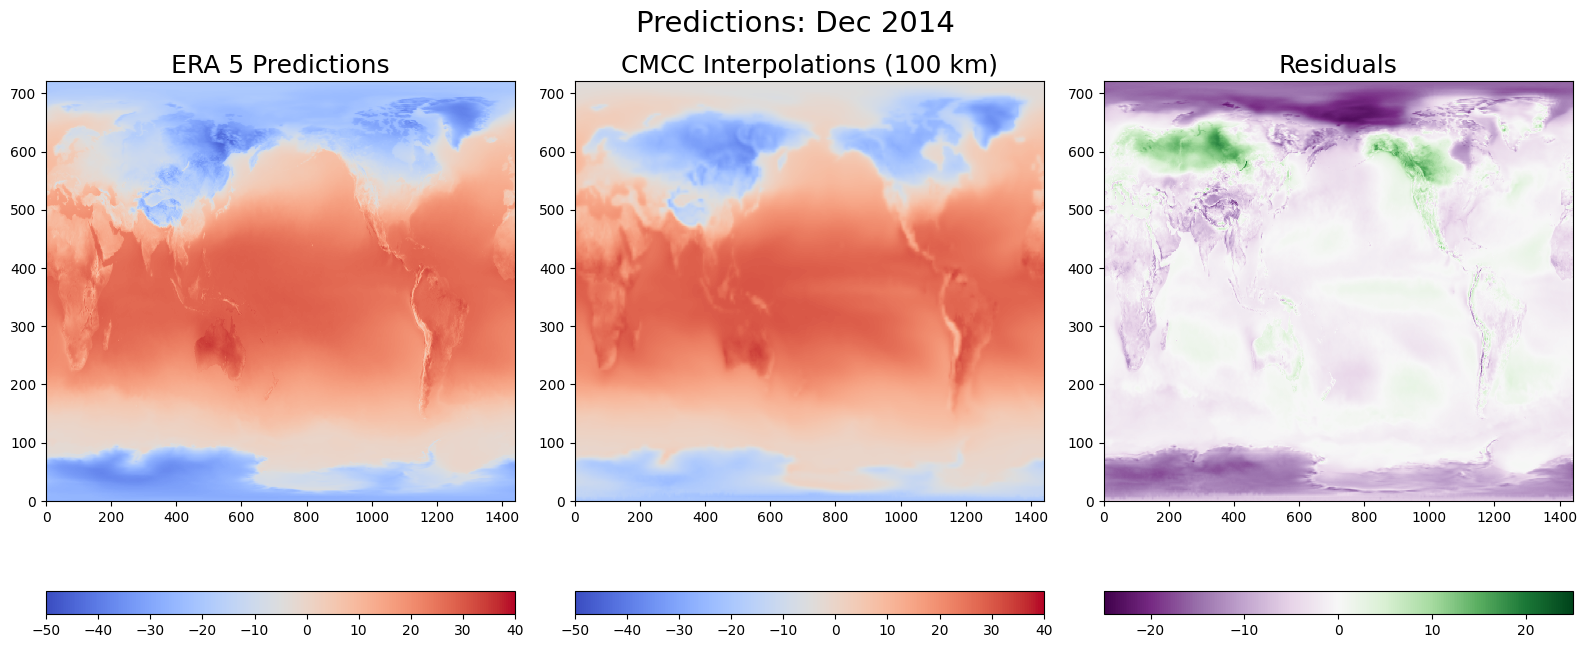

In [94]:
# Plot data
f = cmpi6_interp_files[3].split("185")[0] + "2015.nc"

ncdata4 = nc.Dataset(cmip6intpath + f, "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid4 = era5["t2m"][xx,0,:,:] - 272.15 - ncdata4["tas"][0]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(era5["t2m"][xx,0,:,:].transpose() - 272.15),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
#ax[0][1].pcolormesh(np.rot90(np.flip(ncdata2['tas'][0].transpose()),k=2))
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata4['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid4.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("ERA 5 Predictions", size = 18)
ax[1].set_title("CMCC Interpolations (100 km)", size = 18)
ax[2].set_title("Residuals", size = 18)
fig.suptitle("Predictions: Dec 2014", size = 21)
fig.tight_layout()
plt.show()


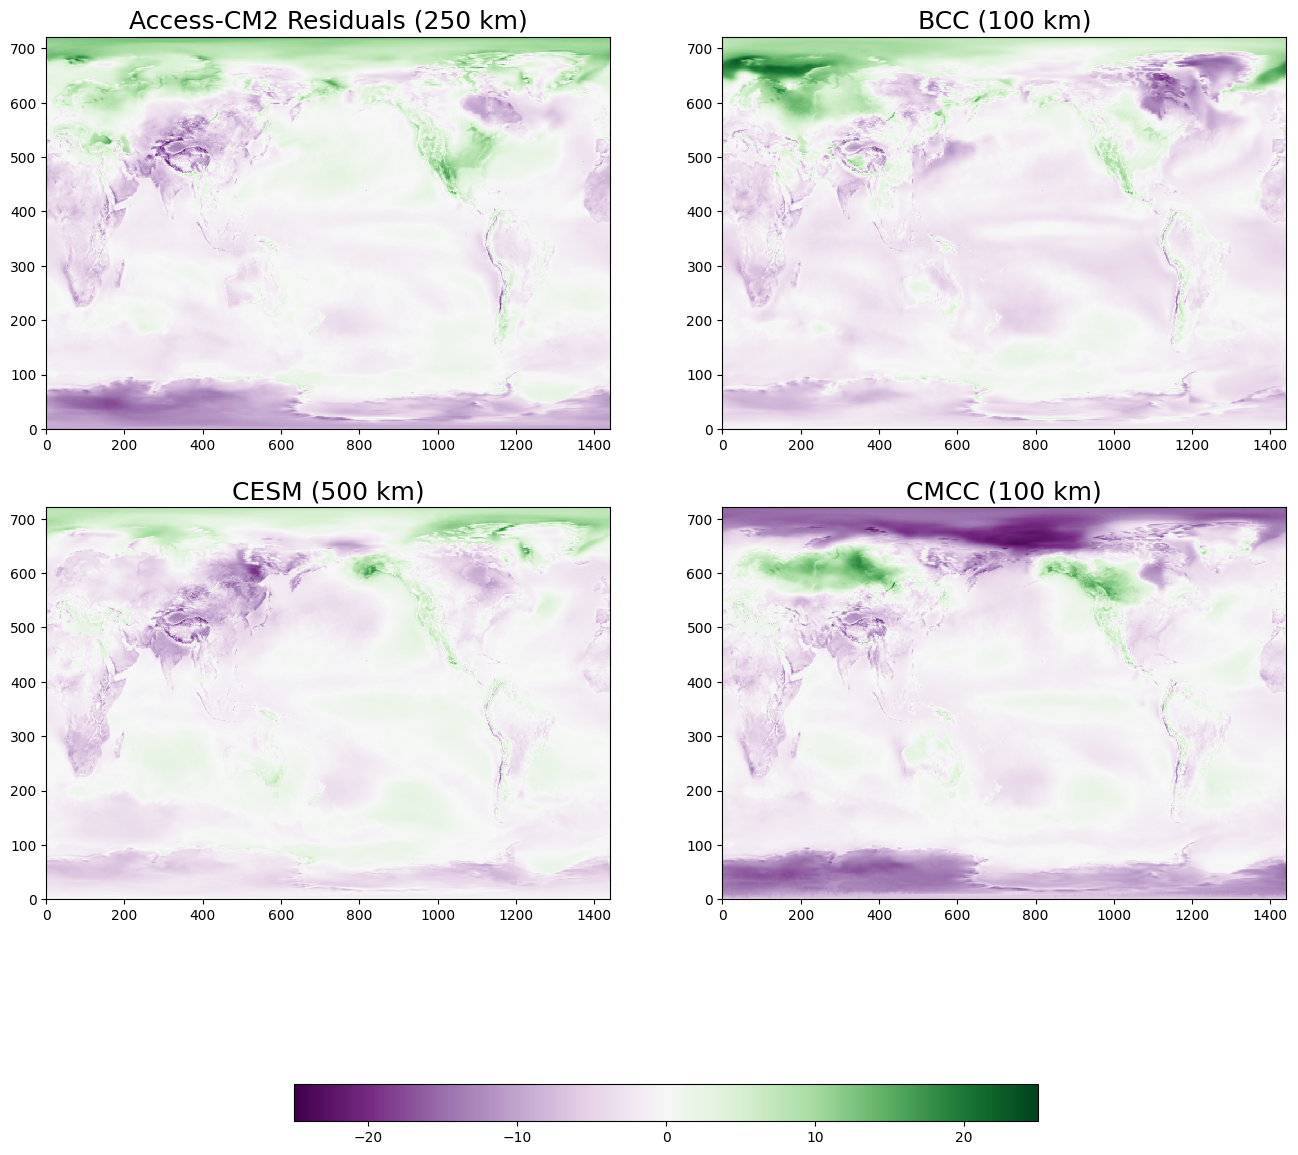

In [92]:
# Compare Residuals across models
fig, ax = plt.subplots(2,2,figsize = (16,16)) 
pcm0 = ax[0][0].pcolormesh(np.rot90(np.flip(resid1.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm1 = ax[0][1].pcolormesh(np.rot90(np.flip(resid2.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm2 = ax[1][0].pcolormesh(np.rot90(np.flip(resid3.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm2 = ax[1][1].pcolormesh(np.rot90(np.flip(resid4.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
#fig.colorbar(pcm0, ax = ax[0], location = "bottom")
#fig.colorbar(pcm1, ax = ax[1], location = "bottom")
ax[0][0].set_title("Access-CM2 Residuals (250 km)", size = 18)
ax[0][1].set_title("BCC (100 km)", size = 18)
ax[1][0].set_title("CESM (500 km)", size = 18)
ax[1][1].set_title("CMCC (100 km)", size = 18)
#fig.suptitle("Residuals: Dec 2014", size = 21)
fig.colorbar(pcm2, ax = ax.ravel(), location = "bottom", shrink = 0.6)
plt.show()


## Comparing Interpolation Methods

In [110]:
#----------------------------------------------------------
# CMIP6 interpolations -- Access-CM2
#----------------------------------------------------------
cmip6intpath = '/home/johnyannotty/NOAA_DATA/CMIP6_Interpolations/'
cmpi6_interp = ["nn","iwd"]
for c,m in enumerate(cmpi6_interp):
    f = file_list[0]
    #f = f.split("185")[0] + "2005-2015.nc"
    f = f.split("185")[0] + "2015" + m + ".nc"
    ncfile = nc.Dataset(cmip6intpath + f,mode='w',format='NETCDF4_CLASSIC')

    lat_dim = ncfile.createDimension('lat', era5_lat.shape[0])     # latitude axis
    lon_dim = ncfile.createDimension('lon', era5_lon.shape[0])    # longitude axis
    time_dim = ncfile.createDimension('time', 12)#tas_data[0].shape[0]) # unlimited axis (can be appended to).

    ncfile.title=f
    ncfile.subtitle='TAS Interpolations'

    lat = ncfile.createVariable('lat', np.float32, ('lat',))
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.float32, ('lon',))
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'months since 1950-01-01'
    time.long_name = 'time'

    temp = ncfile.createVariable('tas',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
    temp.units = 'C'
    temp.standard_name = 't2m'


    # Batch Interpolations....(batch over time, long and lat)
    batch_sz = 100 # number of columns per batch with 1440 rows 
    ncol = era5_lon.shape[0]
    #num_tpds = tas_data[0].shape[0] # number of time periods
    num_tpds = 1 # last 10 years of data
    era5_lat_flip = np.flip(era5_lat)

    for i in tqdm(range(num_tpds),desc = "Time Period",leave=False):
        tm = tas_data[0].shape[0] - num_tpds + i
        for b in tqdm(range(int(np.ceil(era5_lat.shape[0]/batch_sz))),desc = "Batch",leave=False):
            nrow = min(batch_sz, era5_lat.shape[0]-b*batch_sz)
            temp0 = np.array(-999.0).repeat(nrow*ncol).reshape(nrow,ncol)
            for j in range(ncol):
                x0 = era5_lon[j]
                for k in range(nrow):
                    #y0 = era5_lat_flip[b*batch_sz+k]
                    y0 = era5_lat[b*batch_sz+k]
                    if m == 'nn':             
                        temp0[k,j] = nearest_neighbor(x0,y0, np.array(lon_data[0]),np.array(lat_data[0]),tas_data[0][tm])
                    else:
                        temp0[k,j] = invdw(x0, y0, np.array(lon_data[0]),np.array(lat_data[0]),tas_data[0][tm],R=10)
            temp[i,range(100*b,nrow+100*b),:] = temp0

    ncfile.close()

Time Period:   0%|          | 0/1 [00:00<?, ?it/s]

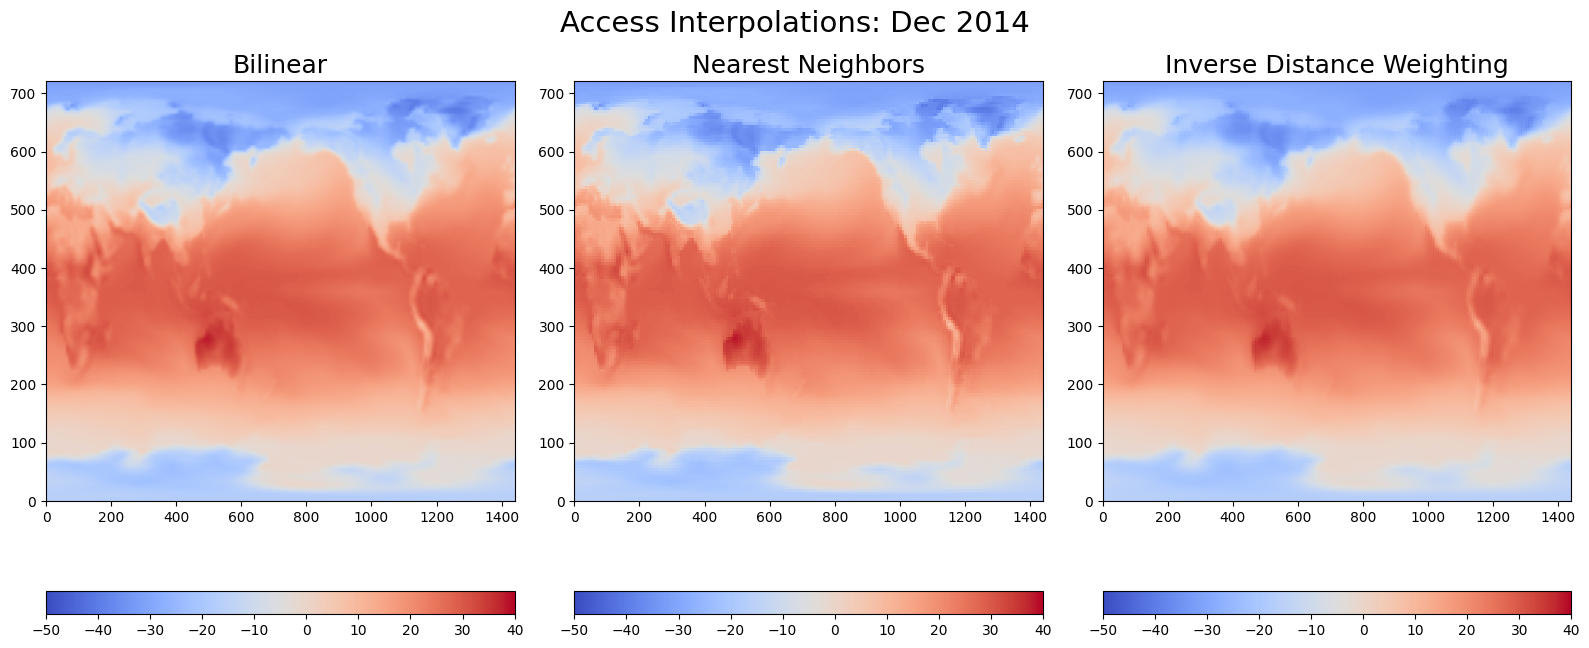

In [112]:
# Plot data
f1 = cmpi6_interp_files[0].split("185")[0] + "2015nn.nc"
f2 = cmpi6_interp_files[0].split("185")[0] + "2015idw.nc"

ncdata5 = nc.Dataset(cmip6intpath + f1, "r")
ncdata6 = nc.Dataset(cmip6intpath + f2, "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid5 = era5["t2m"][xx,0,:,:] - 272.15 - ncdata5["tas"][0]
resid6 = era5["t2m"][xx,0,:,:] - 272.15 - ncdata6["tas"][0]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(ncdata1['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata5['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(ncdata6['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("Bilinear", size = 18)
ax[1].set_title("Nearest Neighbors", size = 18)
ax[2].set_title("Inverse Distance Weighting", size = 18)
fig.suptitle("Access Interpolations: Dec 2014", size = 21)
fig.tight_layout()
plt.show()


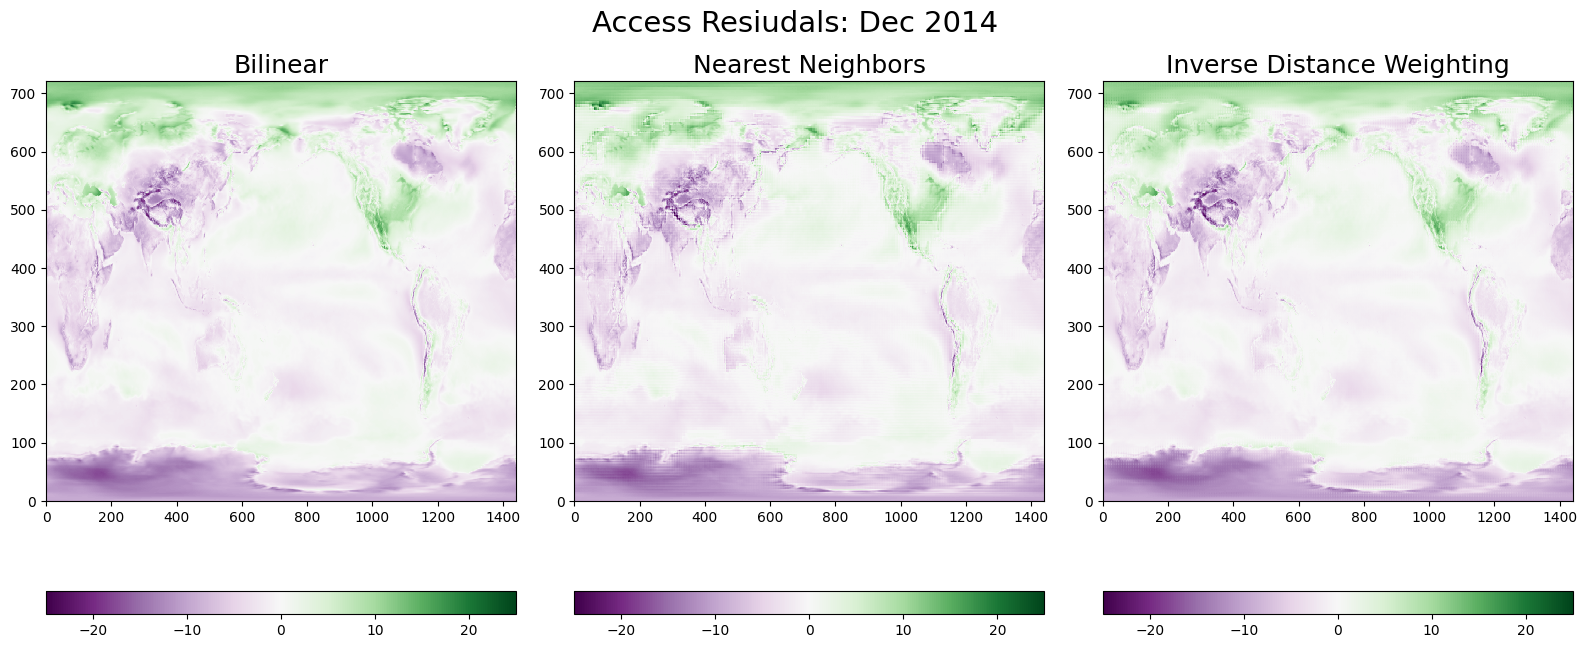

In [116]:
fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(resid1.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(resid5.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid6.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("Bilinear", size = 18)
ax[1].set_title("Nearest Neighbors", size = 18)
ax[2].set_title("Inverse Distance Weighting", size = 18)
fig.suptitle("Access Resiudals: Dec 2014", size = 21)
fig.tight_layout()
plt.show()
